In [1]:
# Mục đích chính của cuộc thi là sử dụng dữ liệu đào tạo của chúng tôi để dự đoán sii hoặc Chỉ số suy giảm nghiêm trọng, 
# đây là thước đo tiêu chuẩn về Sử dụng Internet có vấn đề (PIU).
# Dữ liệu đào tạo bảng (tabular) bao gồm 3.960 hồ sơ của trẻ em và thanh thiếu niên với 81 cột (không bao gồm cột ID).
# Dữ liệu đào tạo chuỗi thời gian (time series) gồm 996 file parquet

In [2]:
import numpy as np
import pandas as pd
import os
import re
import copy
import pickle
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline

import plotly.express as px

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [3]:
import numpy as np, pandas as pd, os
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import plotly.express as px, seaborn as sns, matplotlib.pyplot as plt
sns.set_style('darkgrid')
from sklearn.metrics import make_scorer, cohen_kappa_score
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.simplefilter('ignore')

# **Load dữ liệu dạng bảng (tabular)**

In [4]:
# Đọc các tệp CSV và lưu chúng dưới dạng DataFrame trong pandas
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
data_dictionary = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

In [5]:
train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
test.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Load dữ liệu dạng chuỗi (time series)**

In [7]:
# Hàm xử lý từng tệp parquet chứa dữ liệu dạng time series
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    # Tính toán các thống kê mô tả cho toàn bộ các cột còn lại trong DataFrame, bao gồm:
    # Hàm trả về một tuple gồm:
    #Mảng 1D chứa các giá trị thống kê của dữ liệu.
    #ID tương ứng với tệp.
    return df.describe().values.reshape(-1), filename.split('=')[1]
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


In [8]:
train_ts.head()

,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,id
0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,-0.054638,-0.163923,-0.114302,0.045252,-7.805897,0.000000,46.009533,4027.514893,5.415475e+13,4.438860,2.000000,30.202068,0.633126,0.513286,0.500372,0.132576,34.917873,0.000000,205.862213,108.451317,1.876976e+13,1.825557,0.000000,11.773107,-1.812031,-2.631380,-1.798073,0.0,-89.987045,0.0,0.0,3829.000000,0.000000e+00,1.0,2.0,15.0,-0.701660,-0.619076,-0.536432,0.007953,-32.948602,0.0,2.520257,3958.000000,4.325125e+13,3.0,2.0,17.0,0.015846,-0.141810,-0.104193,0.019257,-6.358004,0.0,8.230733,4029.0,5.630500e+13,5.0,2.0,28.0,0.437897,0.148919,0.223770,0.036048,13.095750,0.0,24.750000,4146.0,6.978000e+13,6.0,2.0,38.0,1.850391,3.580182,1.738203,5.314874,89.422226,0.0,2626.199951,4187.0,8.639500e+13,7.0,2.0,57.0,0745c390
1,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,0.113277,0.093139,-0.106038,0.028960,-6.065619,0.046508,56.437958,3829.466064,4.331149e+13,3.840885,2.000000,232.909103,0.507897,0.541129,0.603787,0.096825,44.034721,0.208482,206.625092,167.600983,2.509136e+13,1.957999,0.000000,5.701968,-1.807955,-2.887664,-1.004992,0.0,-89.654587,0.0,0.0,3098.166748,0.000000e+00,1.0,2.0,223.0,-0.231743,-0.257600,-0.595426,0.000367,-37.326844,0.0,4.000000,3724.000000,2.128500e+13,2.0,2.0,228.0,0.094074,0.068143,-0.228500,0.005257,-13.454103,0.0,10.050480,3812.0,4.360500e+13,4.0,2.0,233.0,0.517859,0.542323,0.312333,0.020598,18.462269,0.0,27.490936,3958.0,6.511000e+13,5.0,2.0,238.0,1.928769,3.234613,2.475326,3.966906,89.080330,1.0,2628.199951,4146.0,8.639500e+13,7.0,2.0,243.0,eaab7a96
2,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,-0.499738,0.046381,-0.181152,0.056544,-11.934993,0.000000,77.305130,4106.425781,4.481677e+13,3.148264,3.000000,100.144516,0.454021,0.510668,0.412588,0.140594,27.367514,0.000000,274.848145,50.734318,2.038156e+13,1.169176,0.000000,5.653936,-1.903281,-3.150104,-1.020313,0.0,-89.540176,0.0,0.0,3853.000000,4.500000e+10,1.0,3.0,97.0,-0.873151,-0.255299,-0.485521,0.005643,-30.154542,0.0,2.918126,4089.625000,2.888500e+13,3.0,3.0,98.0,-0.644505,0.088542,-0.191693,0.018467,-11.570901,0.0,7.863636,4111.0,4.727000e+13,3.0,3.0,99.0,-0.242422,0.381953,0.088555,0.048282,5.009753,0.0,21.022933,4140.0,6.094500e+13,4.0,3.0,100.0,1.021510,1.016589,1.746797,5.066334,86.987267,0.0,2618.199951,4183.0,8.636500e+13,7.0,3.0,134.0,8ec2cc63
3,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,0.007430,0.007583,-0.196510,0.053544,-12.847143,0.000000,9.369678,3958.604492,4.836642e+13,4.273992,2.303057,60.025017,0.586100,0.542189,0.474437,0.103401,32.552841,0.000000,54.104408,122.706802,1.868773e+13,2.023705,1.487018,7.396456,-1.684624,-2.405738,-1.023798,0.0,-89.968369,0.0,0.0,3468.000000,0.000000e+00,1.0,1.0,48.0,-0.530198,-0.412805,-0.556091,0.009947,-34.965618,0.0,0.893617,3841.000000,3.526000e+13,3.0,1.0,53.0,0.022344,0.009674,-0.245181,0.027653,-15.000056,0.0,2.340206,3947.0,4.881000e+13,4.0,1.0,60.0,0.536801,0.443383,0.084469,0.057278,4.816339,0.0,6.200000,4064.0,6.330000e+13,6.0,4.0,67.0,5.908000,2.083693,1.269051,6.134459,89

In [9]:
test_ts.head()

,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,id
0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,-0.316384,0.016009,-0.167890,0.047388,-10.580416,0.000000,42.296310,4053.579102,5.046215e+13,4.470182,3.0,53.201683,0.453665,0.502702,0.585710,0.106351,42.947170,0.000000,208.168976,112.404045,1.942842e+13,1.931421,0.0,14.244914,-1.746094,-2.905339,-1.048372,0.0,-89.833092,0.0,0.0,3824.000000,5.500000e+10,1.0,3.0,41.0,-0.684180,-0.309863,-0.649974,0.006432,-41.541863,0.0,2.392969,4028.666748,3.689000e+13,3.0,3.0,42.0,-0.366849,0.024974,-0.245378,0.023637,-15.086617,0.0,6.926828,4070.0,5.347750e+13,5.0,3.0,50.0,-0.010677,0.400677,0.204727,0.041420,12.220764,0.0,15.000000,4147.000000,6.640875e+13,6.0,3.0,53.0,1.507865,1.666354,1.546979,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0,00115b9f
1,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,-0.004272,0.016859,-0.631731,0.011926,-55.630768,0.655708,16.771982,3838.189453,4.321212e+13,3.909848,3.0,79.435593,0.351545,0.303812,0.623476,0.024331,50.303635,0.468723,95.327438,155.573868,2.497264e+13,1.946892,0.0,6.634319,-1.038711,-1.522690,-1.018787,0.0,-88.761833,0.0,0.0,3098.166748,0.000000e+00,1.0,3.0,68.0,-0.052803,-0.044517,-1.009344,0.008622,-88.386049,0.0,0.500000,3747.000000,2.154000e+13,2.0,3.0,74.0,-0.020622,-0.028179,-1.007728,0.009831,-86.119919,1.0,0.879005,3812.0,4.331000e+13,4.0,3.0,79.0,-0.019081,0.020307,-0.294459,0.010668,-17.483364,1.0,6.141348,3951.187561,6.485500e+13,6.0,3.0,85.0,1.034351,1.946303,1.146284,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0,001f3379


# **Xử lý các feature có kiểu object trong dữ liệu bảng**

In [10]:
# Mô tả một số feature

# Demographics - Information about age and sex of participants.
# Internet Use - Number of hours of using computer/internet per day.
# Children's Global Assessment Scale - Numeric scale used by mental health clinicians to rate the general functioning of youths under the age of 18.
# Physical Measures - Collection of blood pressure, heart rate, height, weight and waist, and hip measurements.
# FitnessGram Vitals and Treadmill - Measurements of cardiovascular fitness assessed using the NHANES treadmill protocol.
# FitnessGram Child - Health related physical fitness assessment measuring five different parameters including aerobic capacity,
# muscular strength, muscular endurance, flexibility, and body composition.
# Bio-electric Impedance Analysis - Measure of key body composition elements, including BMI, fat, muscle, and water content.
# Physical Activity Questionnaire - Information about children's participation in vigorous activities over the last 7 days.
# Sleep Disturbance Scale - Scale to categorize sleep disorders in children.
# Actigraphy - Objective measure of ecological physical activity through a research-grade biotracker. 
# Many values seem to relate to a period after the PCIAT test was carried out. See discussion here.
# Season - for each set of measurements there is a 'season' feature which gives the season of the year when the measurements were carried out.
# These are the only predictive categorical features in the dataset and can be easily preprocessed.

In [11]:
# Lấy danh sách các cột có kiểu dữ liệu là object
categorical_cols_train = train.select_dtypes(include=['object']).columns.tolist()
categorical_cols_train.remove('id')

for season in categorical_cols_train:
    # Fill 0 với các dữ liệu null
    train[season] = train[season].fillna(0)
    train[season] = train[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

train.head()

['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,3,5,0,4,51.0,3,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,3,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,3,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,3,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,0,NaN,NaN,3,3.0,2.0
1,000fd460,2,9,0,0,NaN,3,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,3,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,4,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,3,2.340,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,46.0,64.0,2,0.0,0.0
2,00105258,2,10,1,3,71.0,3,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,3,5.0,7.0,33.0,3,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,3,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,3,38.0,54.0,2,2.0,0.0
3,00115b9f,4,9,0,3,71.0,2,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,2,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,2,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,4,2.451,2,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,2,31.0,45.0,4,0.0,1.0
4,0016bb22,1,18,1,2,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.04,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN


In [12]:
# Lấy danh sách các cột có kiểu dữ liệu là object
categorical_cols_test = test.select_dtypes(include=['object']).columns.tolist()
categorical_cols_test.remove('id')

# In danh sách tên cột
print(categorical_cols_test)

for season in categorical_cols_test:
    test[season] = test[season].fillna(0)
    test[season] = test[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

test.head()

['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,3,5,0,4,51.0,3,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,3,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,3,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,3,3.0
1,000fd460,2,9,0,0,NaN,3,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,3,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,4,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,3,2.340,3,46.0,64.0,2,0.0
2,00105258,2,10,1,3,71.0,3,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,3,5.0,7.0,33.0,3,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,3,38.0,54.0,2,2.0
3,00115b9f,4,9,0,3,71.0,2,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,2,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,2,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,4,2.451,2,31.0,45.0,4,0.0
4,0016bb22,1,18,1,2,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.04,0,NaN,0,NaN,NaN,0,NaN


# **Xét các feature PCIAT trong dữ liệu bảng**

In [13]:
# Lấy danh sách các cột có trong train nhưng không có trong test
columns_only_in_train = set(train.columns) - set(test.columns)

# Chuyển đổi về dạng danh sách nếu cần
columns_only_in_train = list(columns_only_in_train)

print("Các cột có trong train nhưng không có trong test:")
print(columns_only_in_train)

Các cột có trong train nhưng không có trong test:
['PCIAT-PCIAT_07', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_02', 'sii', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_19', 'PCIAT-Season', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_Total', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_12']


In [14]:
# Lấy danh sách các cột có chứa "PCIAT" trong tên
PCIAT_columns = [col for col in train.columns if "PCIAT" in col]

print("Số lượng PCIAT feature:", len(PCIAT_columns))

Số lượng PCIAT feature: 22


Trong tập train ngoại trừ nhãn sii thì có 22 feature PCIAT tuy nhiên trong tập test thì không có các feature này. 
Chúng bao gồm câu trả lời cho 20 câu hỏi (mỗi câu được chấm 5 điểm - thang điểm 100), tổng điểm của các câu hỏi và 'season' khi bài kiểm tra được thực hiện.


In [15]:
# Mô tả tương ứng các cột cột 'PCIAT-PCIAT'
pd.set_option('display.max_colwidth', None)
questions = data_dictionary[data_dictionary.Field.str.contains('PCIAT-PCIAT')]
questions[['Field','Description']]

,Field,Description
55,PCIAT-PCIAT_01,How often does your child disobey time limits you set for online use?
56,PCIAT-PCIAT_02,How often does your child neglect household chores to spend more time online?
57,PCIAT-PCIAT_03,How often does your child prefer to spend time online rather than with the rest of your family?
58,PCIAT-PCIAT_04,How often does your child form new relationships with fellow online users?
59,PCIAT-PCIAT_05,How often do you complain about the amount of time your child spends online?
60,PCIAT-PCIAT_06,How often do your child's grades suffer because of the amount of time he or she spends online?
61,PCIAT-PCIAT_07,How often does your child check his or her e-mail before doing something else?
62,PCIAT-PCIAT_08,How often does your child seem withdrawn from others since discovering the Internet?
63,PCIAT-PCIAT_09,How often does your child become defensive or secretive when asked what he or she does online?
64,PCIAT-PCIAT_10,How often have you caught your child sneaking online against your wishes?


In [16]:
# Mục tiêu sii được lấy từ tổng điểm PCIAT:
#  0-30 cho sii = 0
#  31-49 cho sii = 1
#  50-79 cho sii = 2
#  80-100 cho sii = 3.

In [17]:
# Phân nhóm dữ liệu: PCIAT-PCIAT_Total được chia thành 4 nhóm dựa trên các khoảng giá trị
# Phân tích tần suất: Trong từng nhóm, cột sii được đếm tần suất để xác định các giá trị nào xuất hiện nhiều hoặc ít.

print(train[train['PCIAT-PCIAT_Total']<=30].sii.value_counts())
print(train[(train['PCIAT-PCIAT_Total']>30) 
    & (train['PCIAT-PCIAT_Total']<50)].sii.value_counts())
print(train[(train['PCIAT-PCIAT_Total']>=50) 
    & (train['PCIAT-PCIAT_Total']<80)].sii.value_counts())
print(train[train['PCIAT-PCIAT_Total']>=80].sii.value_counts())

sii
0.0    1594
Name: count, dtype: int64
sii
1.0    730
Name: count, dtype: int64
sii
2.0    378
Name: count, dtype: int64
sii
3.0    34
Name: count, dtype: int64


In [18]:
# Tần suất xuất hiện của các nhãn sii
train.sii.value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

Như vậy các khoảng giá trị của PCIAT-PCIAT_Total hoàn toàn phản ánh đúng nhãn sii

In [19]:
# Hệ số tương quan giữa tất cả các cột trong PCIAT_cols và cột PCIAT-PCIAT_Total.
corr = train[PCIAT_columns].corr()['PCIAT-PCIAT_Total'].sort_values(ascending = False)
corr = pd.DataFrame(corr)
corr.style.background_gradient(cmap='YlOrRd')

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
PCIAT-PCIAT_05,0.830993
PCIAT-PCIAT_15,0.823996
PCIAT-PCIAT_17,0.823708
PCIAT-PCIAT_03,0.823336
PCIAT-PCIAT_18,0.802030
PCIAT-PCIAT_02,0.788802
PCIAT-PCIAT_13,0.771990
PCIAT-PCIAT_08,0.770499
PCIAT-PCIAT_16,0.769422


In [20]:
# Chúng tôi loại bỏ tất cả các feature PCIAT khỏi tập dữ liệu ngoại trừ PCIAT-PCIAT_Total có thể được sử dụng làm mục tiêu hồi quy.
# Ở tập dữ liệu train chúng ta sẽ bỏ tất cả các cột trong danh sách PCIAT_cols (là các câu hỏi PCIAT-PCIAT) và chỉ giữ lại PCIAT-PCIAT_Total
PCIAT_columns.remove('PCIAT-PCIAT_Total')
train = train.drop(columns = PCIAT_columns)
train.head(10)

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,3,5,0,4,51.0,3,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,3,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,3,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,55.0,0,NaN,NaN,3,3.0,2.0
1,000fd460,2,9,0,0,NaN,3,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,3,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,4,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,3,2.340,0.0,3,46.0,64.0,2,0.0,0.0
2,00105258,2,10,1,3,71.0,3,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,3,5.0,7.0,33.0,3,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,28.0,3,38.0,54.0,2,2.0,0.0
3,00115b9f,4,9,0,3,71.0,2,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,2,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,2,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,4,2.451,44.0,2,31.0,45.0,4,0.0,1.0
4,0016bb22,1,18,1,2,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.04,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
5,001f3379,1,13,1,4,50.0,2,22.279952,59.50,112.2,NaN,60.0,73.0,102.0,0,NaN,NaN,NaN,2,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,2,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,0,NaN,1,4.110,34.0,2,40.0,56.0,1,0.0,1.0
6,0038ba98,3,10,0,0,NaN,3,19.660760,55.00,84.6,NaN,123.0,83.0,163.0,0,NaN,NaN,NaN,3,9.0,1.0,NaN,NaN,NaN,NaN,2.0,0.0,11.0,1.0,11.0,1.0,11.0,1.0,3,2.0,3.78271,19.6629,1135.860,1817.38,16.32750,63.2470,14.7000,4.96291,21.35300,2.0,30.8936,16.02590,59.4643,26.1957,47.2211,0,NaN,4,3.670,20.0,4,27.0,40.0,3,3.0,0.0
7,0068a485,3,10,1,0,NaN,3,16.861286,59.25,84.2,27.0,71.0,90.0,116.0,0,NaN,NaN,NaN,3,0.0,0.0,12.6,2.0,11.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3,3.0,4.05726,16.8631,1180.040,1888.06,21.94000,67.9527,13.6092,3.25395,16.24740,2.0,28.5367,17.47600,63.8954,28.7680,50.4767,0,NaN,3,1.270,NaN,0,NaN,NaN,3,2.0,NaN
8,0069fbed,2,15,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,NaN,2,2.0,NaN
9,0083e397,2,19,1,2,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   int64  
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             3960 non-null   int64  
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3960 non-null   int64  
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

# **Phân tích dữ liệu**

Text(0.5, 1.0, 'Count of sii')

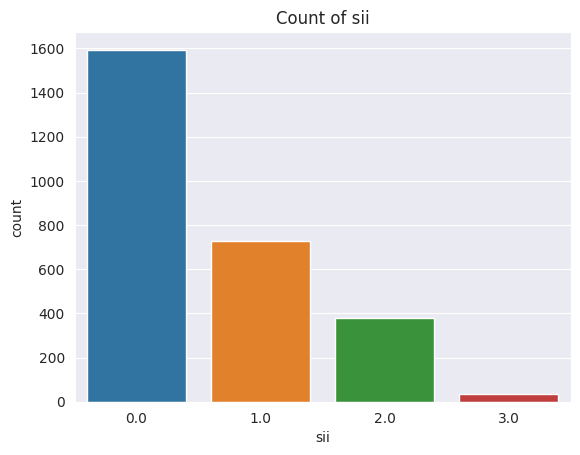

In [22]:
# Hiển thị tần suất xuất hiện của từng giá trị trong cột sii.
sns.countplot(train, x = 'sii').set_title('Count of sii')

In [23]:
# Đếm số lượng hàng thiếu cả 'sii' và 'PCIAT-PCIAT_Total'
missing_both = train[(train['sii'].isna()) & (train['PCIAT-PCIAT_Total'].isna())]
print("Số hàng thiếu cả 'sii' và 'PCIAT-PCIAT_Total':", len(missing_both))

Số hàng thiếu cả 'sii' và 'PCIAT-PCIAT_Total': 1224


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   int64  
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             3960 non-null   int64  
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3960 non-null   int64  
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [25]:
# Nhận thấy trong tập train có 3960 hàng, trong đó sii 2736 non-null -> 1224 null, PCIAT-PCIAT_Total 2736 non-null -> 1224 null, 
# và ta vừa thống kê có 1224 hàng vừa thiếu hàng thiếu cả 'sii' và 'PCIAT-PCIAT_Total'

In [26]:
# Như vậy các hàng có nhãn sii null thì PCIAT-PCIAT_Total cũng null vậy nên không thể xác định, phân phân loại
# Loại bỏ các hàng có sii null
train = train.dropna(subset='sii')
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      2736 non-null   object 
 1   Basic_Demos-Enroll_Season               2736 non-null   int64  
 2   Basic_Demos-Age                         2736 non-null   int64  
 3   Basic_Demos-Sex                         2736 non-null   int64  
 4   CGAS-Season                             2736 non-null   int64  
 5   CGAS-CGAS_Score                         2342 non-null   float64
 6   Physical-Season                         2736 non-null   int64  
 7   Physical-BMI                            2527 non-null   float64
 8   Physical-Height                         2530 non-null   float64
 9   Physical-Weight                         2572 non-null   float64
 10  Physical-Waist_Circumference            483 non-null    float64
 

In [27]:
# Kết hợp tabular data và time series data
# Kết hợp DataFrame train và train_ts, test và test_ts
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Columns: 157 entries, id to stat_95
dtypes: float64(144), int64(12), object(1)
memory usage: 3.3+ MB


In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 155 entries, id to stat_95
dtypes: float64(142), int64(12), object(1)
memory usage: 24.3+ KB


In [30]:
# Lấy danh sách các cột có trong train nhưng không có trong test
columns_only_in_train = set(train.columns) - set(test.columns)

# Chuyển đổi về dạng danh sách nếu cần
columns_only_in_train = list(columns_only_in_train)

print("Các cột có trong train nhưng không có trong test:")
print(columns_only_in_train)

Các cột có trong train nhưng không có trong test:
['sii', 'PCIAT-PCIAT_Total']


In [31]:
# Như vậy lúc này tập train và test có các feature về cơ bản giống nhau trừ 2 cột 'PCIAT-PCIAT_Total', 'sii'

# **Feature Selection**

In [32]:
# Với số lượng lớn các feature để lựa chọn, tôi quyết định thực hiện một số lựa chọn feature và kiểm tra tác động của chúng lên mô hình.
# Ở đây, tôi chọn các tính năng có mối tương quan mạnh nhất với tổng PCIAT và loại bỏ các tính năng yếu hơn.

In [33]:
# Bỏ cột 'id' khỏi DataFrame train
train_no_id = train.drop(columns=['id'])
train_no_id.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,3,5,0,4,51.0,3,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,3,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,3,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,55.0,0,NaN,NaN,3,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,9,0,0,NaN,3,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,3,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,4,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,3,2.340,0.0,3,46.0,64.0,2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,10,1,3,71.0,3,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,3,5.0,7.0,33.0,3,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,28.0,3,38.0,54.0,2,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,9,0,3,71.0,2,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,2,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,2,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,4,2.451,44.0,2,31.0,45.0,4,0.0,1.0,4

In [34]:
# Tính hệ số tương quan giữa PCIAT-PCIAT_Total và các cột còn lại
correlation_with_pciat = pd.DataFrame(train_no_id.corr()['PCIAT-PCIAT_Total']
                                      .sort_values(ascending=False))
correlation_table_styled = correlation_with_pciat.style.background_gradient(cmap='coolwarm')
correlation_table_styled

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
sii,0.899681
Physical-Height,0.420765
Basic_Demos-Age,0.409559
PreInt_EduHx-computerinternet_hoursday,0.374124
Physical-Weight,0.353048
Physical-Waist_Circumference,0.327013
FGC-FGC_CU,0.287494
BIA-BIA_BMI,0.248060
Physical-BMI,0.240858


In [35]:
# Lọc các cột có tương quan lớn hơn 0.1 hoặc nhỏ hơn -0.1
selection = correlation_with_pciat[(correlation_with_pciat['PCIAT-PCIAT_Total']>.1)
                                    | (correlation_with_pciat['PCIAT-PCIAT_Total']<-.1)]
selection = [val for val in selection.index]
selection.remove('PCIAT-PCIAT_Total')
selection.remove('sii')
selection

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'Physical-BMI',
 'SDS-SDS_Total_T',
 'SDS-SDS_Total_Raw',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'FGC-FGC_GSD',
 'Physical-Systolic_BP',
 'FGC-FGC_GSND',
 'FGC-FGC_TL',
 'stat_37',
 'stat_80',
 'stat_17',
 'PAQ_C-Season',
 'stat_32',
 'BIA-BIA_FFMI',
 'stat_77',
 'stat_29',
 'stat_36',
 'stat_65',
 'stat_84',
 'stat_51',
 'FGC-FGC_SRR_Zone',
 'stat_30',
 'stat_24',
 'stat_85',
 'stat_87',
 'FGC-FGC_SRL_Zone',
 'stat_63',
 'stat_75',
 'stat_27',
 'stat_15']

In [36]:
# Thống kê các cột bị thiếu dữ liệu
missing_data = train.isna().sum()

missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

missing_data_df = missing_data.to_frame(name='Missing Values')
missing_data_df['Percentage'] = (missing_data_df['Missing Values'] / len(train)) * 100

missing_data_df


,Missing Values,Percentage
PAQ_A-PAQ_A_Total,2373,86.732456
Physical-Waist_Circumference,2253,82.346491
Fitness_Endurance-Time_Mins,2008,73.391813
Fitness_Endurance-Time_Sec,2008,73.391813
Fitness_Endurance-Max_Stage,2005,73.282164
...,...,...
Physical-BMI,209,7.638889
SDS-SDS_Total_Raw,209,7.638889
Physical-Height,206,7.529240
Physical-Weight,164,5.994152


In [37]:
# Có rất nhiều feature bị thiếu dữ liệu, chúng ta có thể loại bỏ bớt các feature có quá nhiều dữ liệu thiếu (VD: 50% dữ liệu thiếu) và điền dữ liệu trung 
# bình của feature cho những chỗ thiếu dữ liệu. Tuy nhiên bởi vì chúng tôi sẽ sử dụng các model LightGBM, XGBoost, CatBoost, những model này có thể
# handle được cả các null data nên không nhất thiết phải xử lý null data

In [38]:
# Phân tích thống kê cho các cột trong danh sách selection, cụ thể là giá trị nhỏ nhất và lớn nhất.
# Hiển thị kết quả một cách trực quan với màu sắc giúp nhận diện nhanh các giá trị đặc biệt như min và max.
describe = train[selection].describe().T
describe = describe[['min','max']].sort_index()
describe.style.background_gradient(cmap='YlOrRd')

,min,max
BIA-BIA_BMI,0.048267,48.375400
BIA-BIA_FFMI,7.864850,217.771000
BIA-BIA_Frame_num,1.000000,3.000000
Basic_Demos-Age,5.000000,22.000000
FGC-FGC_CU,0.000000,115.000000
FGC-FGC_GSD,0.000000,123.800000
FGC-FGC_GSND,0.000000,124.000000
FGC-FGC_PU,0.000000,51.000000
FGC-FGC_SRL_Zone,0.000000,1.000000
FGC-FGC_SRR_Zone,0.000000,1.000000


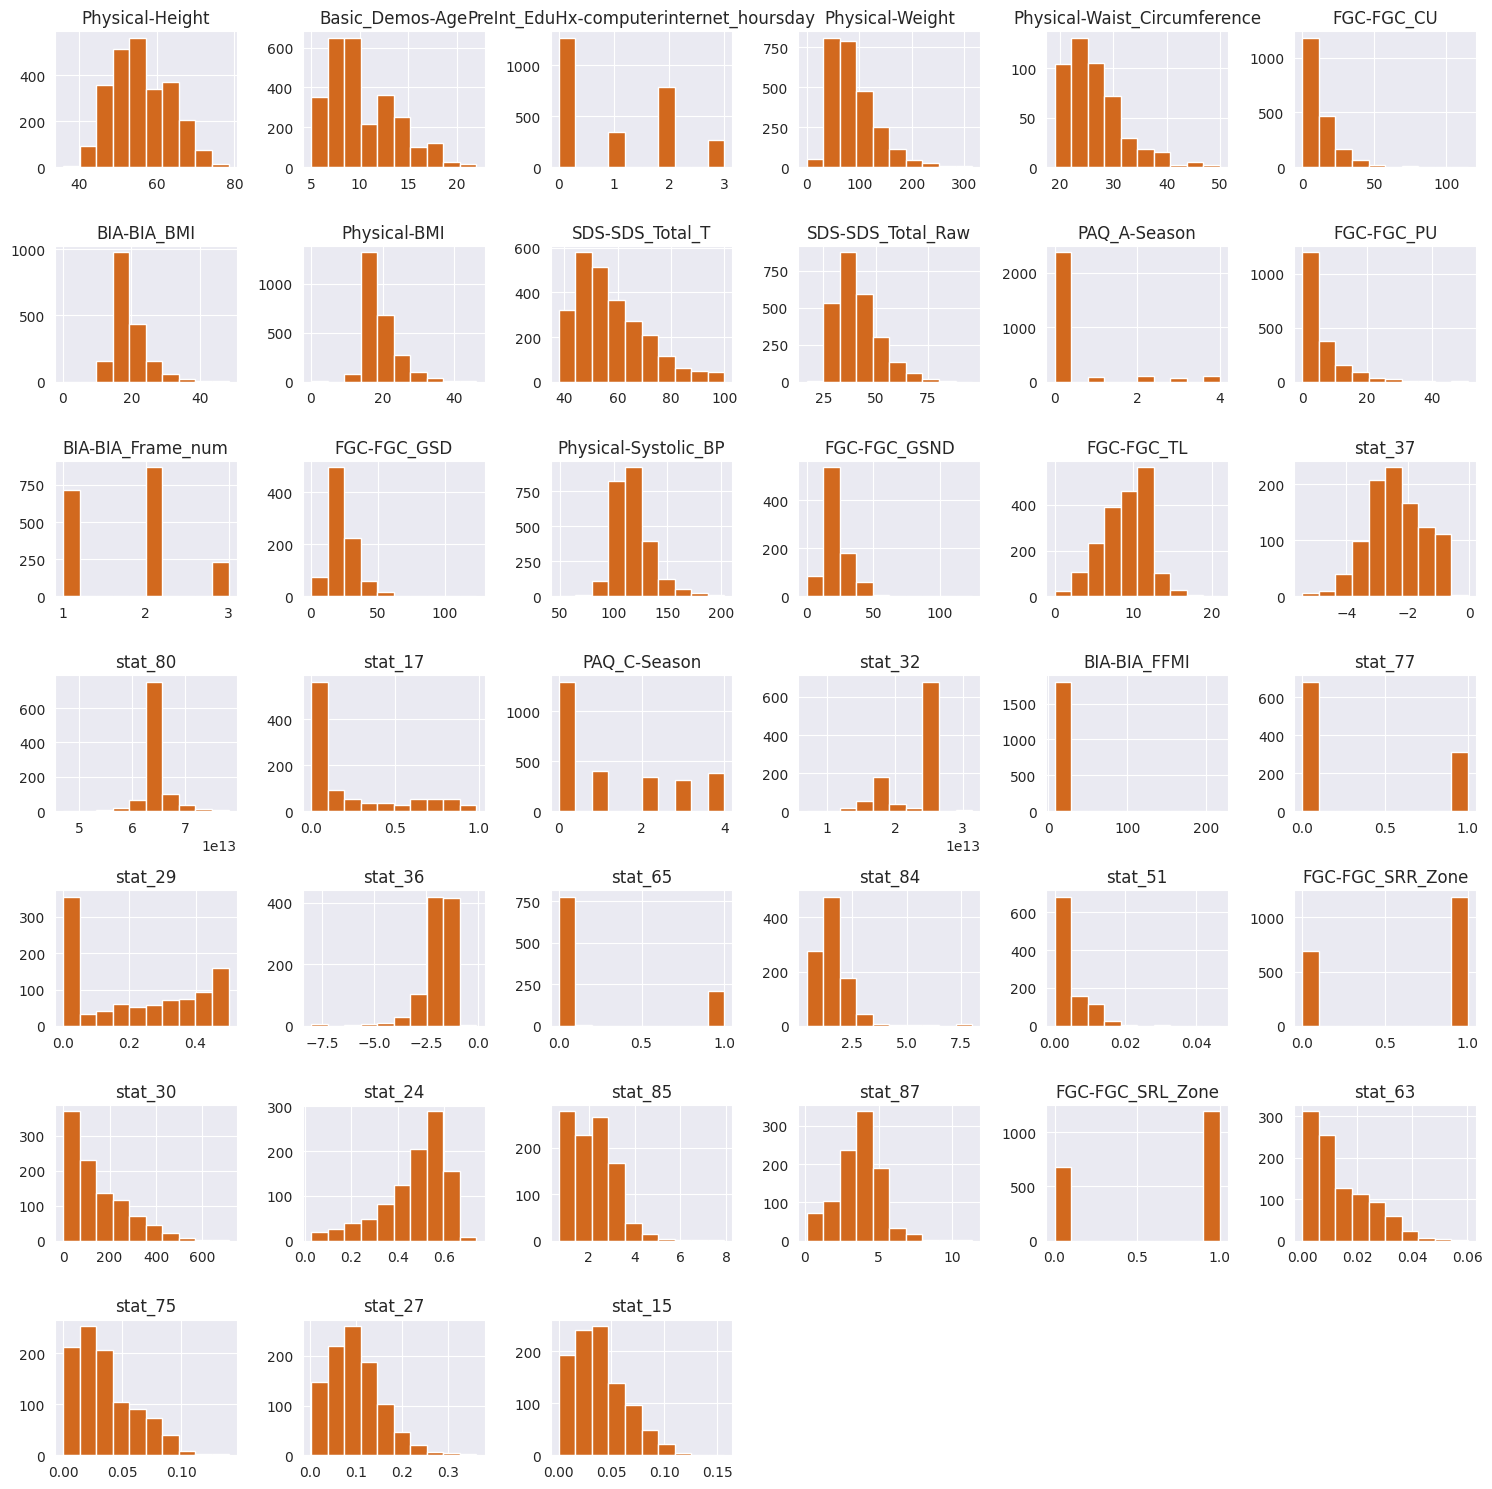

In [39]:
# Vẽ biểu đồ tần suất (histogram) cho các cột trong DataFrame train, dựa trên danh sách các cột trong selection. 
# Mục đích là để kiểm tra phân phối của các giá trị trong các cột này.

train[selection].hist(figsize=(15,15), grid = True, color = 'chocolate')
plt.tight_layout()

In [40]:
# Dữ liệu đào tạo bao gồm 3.960 hồ sơ của trẻ em và thanh thiếu niên với 81 cột (không bao gồm cột ID).
# Kết quả của Bài kiểm tra nghiện Internet giữa cha mẹ và con cái (PCIAT) có tầm quan trọng đặc biệt trong dữ liệu.
# Mục tiêu thực sự được lấy từ trường PCIAT-PCIAT_Total (được chấm điểm trên thang điểm 100).
# Do đó, chúng ta có thể chọn dự đoán Tổng PCIAT và chuyển đổi thành sii (biến đây thành vấn đề hồi quy) hoặc 
# giữ nguyên sii (biến đây thành vấn đề phân loại).

# **Train Classification model với "sii" là nhãn**

In [41]:
X = train[selection]
test = test[selection]
y = train.sii

In [42]:
# Tính hệ số Kappa (Quadratic Weighted Kappa) -  hệ số Kaggle sử dụng để tính điểm

def quadratic_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')
kappa_scorer = make_scorer(quadratic_kappa)

In [43]:
params = {'max_depth': 3, 
          'n_estimators': 202, 
          'learning_rate': 0.07956777025142073, 
          'subsample': 0.8197358255094112, 
          'colsample_bytree': 0.645036755035947}

skf = StratifiedKFold(n_splits=10)

clf = xgb.XGBClassifier(**params)

In [44]:
# Đánh giá hiệu năng mô hình bằng cách sử dụng cross-validation (phân chia chéo) với thang đo Kappa Quadratic Weighted (QWK).

scores = cross_val_score(clf, X, y, cv=skf, scoring=kappa_scorer)
print("QWK Scores:", scores)
print("Mean QWK Score:", np.mean(scores))

QWK Scores: [0.3481965  0.28205688 0.38015317 0.33561    0.49039276 0.34816681
 0.32957852 0.39951339 0.3595981  0.34619289]
Mean QWK Score: 0.361945901885532


In [45]:
# Thực hiện huấn luyện mô hình học máy  và sau đó lấy tầm quan trọng của từng đặc trưng (feature importance) từ mô hình đã được huấn luyện. 
# Tầm quan trọng này giúp đánh giá mức độ ảnh hưởng của các đặc trưng đầu vào (X.columns) đối với biến mục tiêu (y)
clf.fit(X,y)
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

Basic_Demos-Age                           0.087631
PreInt_EduHx-computerinternet_hoursday    0.061411
Physical-Height                           0.038305
SDS-SDS_Total_T                           0.035714
Physical-Weight                           0.033101
SDS-SDS_Total_Raw                         0.031405
FGC-FGC_CU                                0.027492
FGC-FGC_PU                                0.025539
PAQ_C-Season                              0.024926
stat_30                                   0.024538
stat_75                                   0.024436
Physical-Waist_Circumference              0.024371
Physical-BMI                              0.024183
stat_32                                   0.024139
BIA-BIA_FFMI                              0.024074
stat_84                                   0.023571
stat_85                                   0.023560
stat_37                                   0.023507
stat_80                                   0.023233
Physical-Systolic_BP           

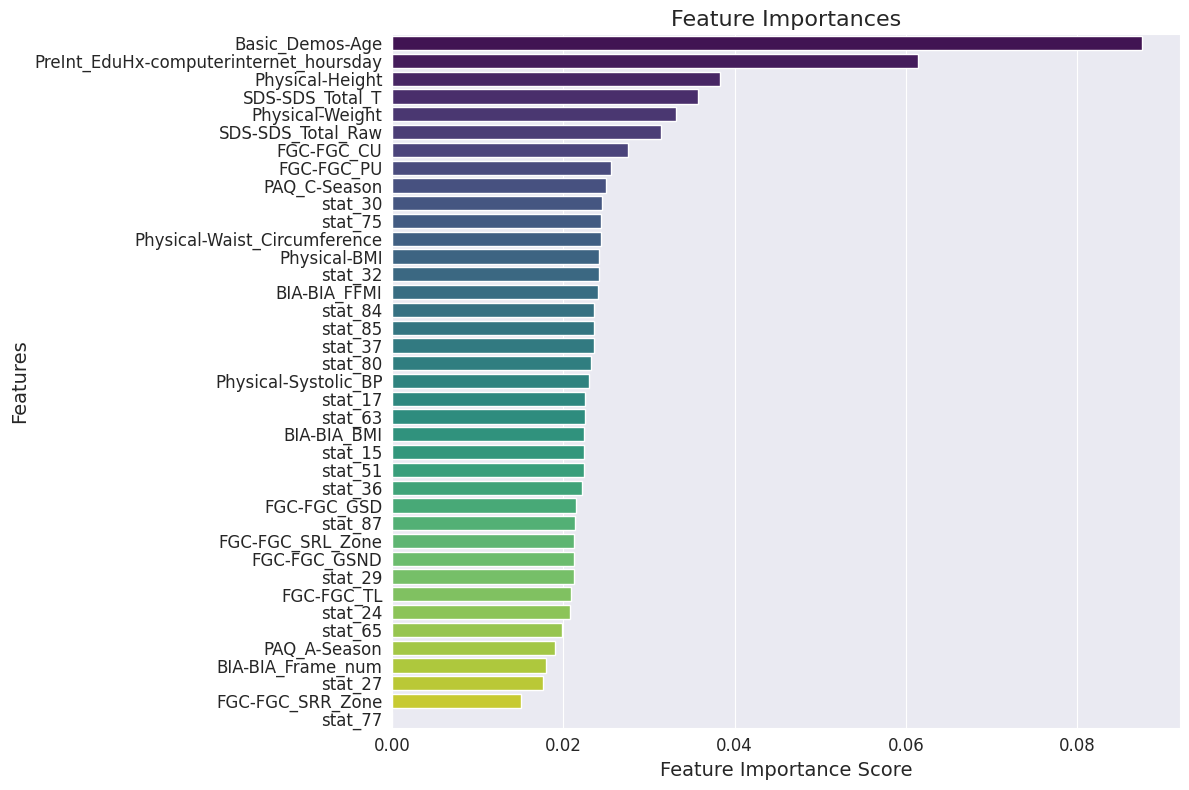

In [46]:
plt.figure(figsize=(12, 8)) 
sns.barplot(x=feature_imp, y=feature_imp.index, palette='viridis')
plt.xlabel('Feature Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title("Feature Importances", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [47]:
# sử dụng PermutationImportance để tính toán tầm quan trọng của từng đặc trưng bằng cách sử dụng hoán vị ngẫu nhiên. 
# Sau đó, tầm quan trọng của các đặc trưng được hiển thị với mô-đun eli5.show_weights()

perm = PermutationImportance(clf, random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0524 ± 0.0093,PreInt_EduHx-computerinternet_hoursday
0.0385 ± 0.0094,SDS-SDS_Total_T
0.0337 ± 0.0068,Basic_Demos-Age
0.0199 ± 0.0048,BIA-BIA_FFMI
0.0190 ± 0.0046,Physical-Height
0.0189 ± 0.0069,FGC-FGC_CU
0.0175 ± 0.0032,Physical-Weight
0.0158 ± 0.0026,Physical-Systolic_BP
0.0139 ± 0.0058,Physical-BMI
0.0136 ± 0.0069,SDS-SDS_Total_Raw


# **Regression Model với target là PCIAT-PCIAT_Total**

In [48]:
# Chúng tôi sử dụng ensemble gồm LightGBM, XGBoost, CatBoost để dự đoán PCIAT-PCIAT_Total
# Chúng tôi điều chỉnh hàm kappa bậc hai để chuyển đổi tổng điểm PCIAT thành các loại sii, mang lại kết quả tốt hơn.
# Tôi thấy rằng việc thêm hệ số tỷ lệ 1,25 vào điểm số sẽ mang lại điểm QWK tổng thể tốt hơn.
# Hiệu ứng của việc này là giảm ngưỡng điểm từ 30, 50, 80 xuống 24, 40, 64. Hoàn toàn có thể tìm thấy các giá trị thậm chí còn tốt hơn.
# Điểm QWK cuối cùng là 0.437 tốt hơn 0.361 của Classification model.

In [49]:
X = train[selection]
test = test[selection]
y = train['PCIAT-PCIAT_Total']

In [50]:
# Chuyển đổi kết quả dự đoán PCIAT-PCIAT_Total sang sii
def convert(scores):
    scores = np.array(scores)*1.252
    bins = np.zeros_like(scores)
    bins[scores <= 30] = 0
    bins[(scores > 30) & (scores < 50)] = 1
    bins[(scores >= 50) & (scores < 80)] = 2
    bins[scores >= 80] = 3
    return bins

In [51]:
def quadratic_kappa(y_true, y_pred):
    y_true_cat = convert(y_true)
    y_pred_cat = convert(y_pred)
    return cohen_kappa_score(y_true_cat, y_pred_cat, weights='quadratic')

kappa_scorer = make_scorer(quadratic_kappa, greater_is_better=True)

In [52]:
# Các tham số cho model

SEED = 42
n_splits = 5

# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01  # Increased from 2.68e-06
}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10  # Increase this value
}

In [53]:
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

# Combine models using Voting Regressor
model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])

In [54]:
scores = cross_val_score(model, X, y, cv=skf, scoring=kappa_scorer)
print("QWK Scores:", scores)
print("Mean QWK Score:", np.mean(scores))

QWK Scores: [0.40038652 0.4464807  0.51692337 0.42710416 0.49397407 0.3831448
 0.46553809 0.39453245 0.43538835 0.41321297]
Mean QWK Score: 0.43766854680783246


In [55]:
test.head()

,Physical-Height,Basic_Demos-Age,PreInt_EduHx-computerinternet_hoursday,Physical-Weight,Physical-Waist_Circumference,FGC-FGC_CU,BIA-BIA_BMI,Physical-BMI,SDS-SDS_Total_T,SDS-SDS_Total_Raw,PAQ_A-Season,FGC-FGC_PU,BIA-BIA_Frame_num,FGC-FGC_GSD,Physical-Systolic_BP,FGC-FGC_GSND,FGC-FGC_TL,stat_37,stat_80,stat_17,PAQ_C-Season,stat_32,BIA-BIA_FFMI,stat_77,stat_29,stat_36,stat_65,stat_84,stat_51,FGC-FGC_SRR_Zone,stat_30,stat_24,stat_85,stat_87,FGC-FGC_SRL_Zone,stat_63,stat_75,stat_27,stat_15
0,46.0,5,3.0,50.8,NaN,0.0,16.8792,16.877316,NaN,NaN,0,0.0,1.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,0,NaN,13.8177,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,48.0,9,0.0,46.0,22.0,3.0,14.0371,14.035590,64.0,46.0,0,5.0,1.0,NaN,122.0,NaN,3.0,NaN,NaN,NaN,3,NaN,12.8254,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,56.5,10,2.0,75.6,NaN,20.0,NaN,16.648696,54.0,38.0,0,7.0,NaN,14.7,117.0,10.2,5.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,56.0,9,0.0,81.6,NaN,18.0,18.2943,18.292347,45.0,31.0,0,5.0,2.0,NaN,117.0,NaN,7.0,-2.905339,6.640875e+13,0.0,4,1.942842e+13,14.0740,0.0,0.0,-1.746094,0.0,1.507865,0.006432,0.0,208.168976,0.453665,1.666354,4.004276,0.0,0.023637,0.04142,0.106351,0.047388
4,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [57]:
model.fit(X,y)
preds = model.predict(test)
preds = convert(preds) # convert raw scores to sii categories if using regressor
preds = pd.Series(preds)
preds.index = test.index
submission = pd.DataFrame({
        'id': sample['id'],
        'sii': preds.astype(int)
    })
submission.to_csv('submission.csv', index=False)
submission

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,1
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,1
